In [1]:
import os
import pandas as pd

def load_predictions_data():
    predictions_path=os.path.join("datasets", "predictions_prod_v2.csv")
    return pd.read_csv(predictions_path, dtype={"predictions_route_id": str, "predictions_stop_id": str})

In [2]:
data = load_predictions_data()
data_copy = data.copy()

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

data = data_copy.copy()

data = data.dropna(subset=["predictions_arrival_time", "ve_arrival_time"])
# data = data[data["predictions_route_id"] == 'Mattapan']

data["predictions_error"] = data["ve_arrival_time"] - data["predictions_arrival_time"]
data = data[data["predictions_error"] >= -600]
data = data[data["predictions_error"] <= 600]
data = data[data["predictions_arrival_time"] - data["predictions_file_timestamp"] < 30*60]
data = data[data["predictions_arrival_time"] - data["predictions_file_timestamp"] > -30]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["predictions_route_id"]):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]
    
train_labels = strat_train_set["predictions_error"].copy()
test_labels = strat_test_set["predictions_error"].copy()

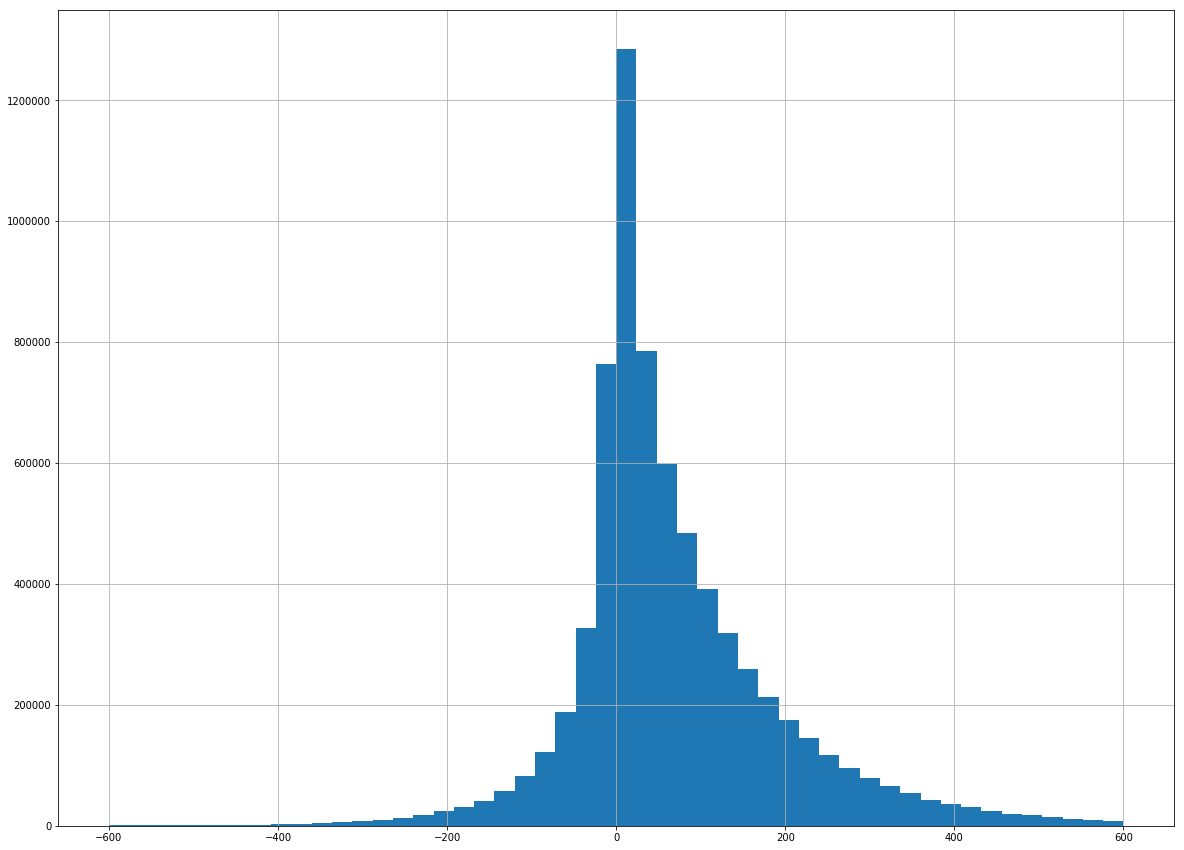

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
data["predictions_error"].hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
import numpy as np
our_rmse = np.sqrt(data["predictions_error"].apply(lambda x: x**2).sum() / len(data["predictions_error"]))
our_rmse

140.32625567385264

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import numpy as np

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include_stops_away=False, include_route_id=False):
        self.include_stops_away = include_stops_away
        self.include_route_id = include_route_id
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(["predictions_id", 
                       "predictions_trip_id", 
                       "predictions_stop_sequence",
                       "predictions_vehicle_event_id",
                       "predictions_vehicle_id",
                       "predictions_file_timestamp",],
                      axis=1)

class IsStoppedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        result = X.copy()
        result['is_stopped'] = X['predictions_boarding_status'].notnull()
        return result.drop('predictions_boarding_status', axis=1)

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        new_data = X.copy()
        datetimes = new_data['predictions_file_timestamp'].apply(
            lambda x: datetime.fromtimestamp(x),
        )
        predictions_day_of_week = datetimes.apply(lambda x: x.weekday())
        predictions_time_bin = datetimes.apply(self._timestamp_bin)
        new_data['predictions_day_of_week'] = predictions_day_of_week
        new_data['predictions_time_bin'] = predictions_time_bin
        return new_data
    
    def _timestamp_bin(self, timestamp):
        return timestamp.hour * 4 + timestamp.minute // 15

class ColumnOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        enc = OneHotEncoder()
        one_hotted = enc.fit_transform(X[self.column].values.reshape(-1,1))
        return np.concatenate((X.drop(self.column, axis=1), one_hotted), axis=1)
    
class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print(X.info())
        return X

class AccuracyBinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy["accuracy_bin"] = (copy['predictions_arrival_time'] - copy['predictions_file_timestamp']).apply(self._accuracy_bin)
        return copy
        
    def _accuracy_bin(self, seconds):
        if seconds < -30:
            return 'na-'
        elif -30 <= seconds < 180:
            return '0-3'
        elif 180 <= seconds < 360:
            return '3-6'
        elif 360 <= seconds < 720:
            return '6-12'
        elif 720 <= seconds < 1800:
            return '12-30'
        else:
            return 'na+'

class DenseMatrixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

passthrough_features = [ #'predictions_arrival_time',
                        #'is_stopped',
                        #'predictions_stops_away',
                        #'predictions_file_timestamp',
                        #'predictions_direction_id'
]

column_transformer = ColumnTransformer([
#     ('pass', 'passthrough', passthrough_features),
    ('1hot', OneHotEncoder(), [#'predictions_stop_id', 
                               #'predictions_route_id', 
                               #'predictions_day_of_week',
                                'accuracy_bin',
                               #'predictions_time_bin'
                              ])
])

predictions_pipeline = Pipeline([
    ('timestamp', TimestampTransformer()),
    ('is_stopped', IsStoppedTransformer()),
    ('accuracy_bin', AccuracyBinTransformer()),
    ('col_transformer', column_transformer),
    #('dense_matrix', DenseMatrixTransformer()),
    #('std_scaler', StandardScaler()),
])

In [8]:
fitted = predictions_pipeline.fit_transform(strat_train_set)

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(fitted, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
predictions = lin_reg.predict(fitted)
predictions

array([85.27519315, 65.42921153, 65.42921153, ..., 85.27519315,
       85.27519315, 85.27519315])

In [11]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(train_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

121.41679188716182

In [12]:
ct = predictions_pipeline.named_steps['col_transformer']
(_, _, passthrough_cols) = ct.transformers[0]
onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

features = passthrough_cols + onehot_cols.tolist()

In [13]:
sorted(zip(lin_reg.coef_, features))

[(-45.10243514971253, 'accuracy_bin'),
 (-21.071238166980855, 'x0_12-30'),
 (-1.0072762137042275, 'x0_3-6'),
 (18.838705407687538, 'x0_0-3')]

In [14]:
lin_reg.intercept_

66.43648774162205

In [15]:
sorted(zip(lin_reg.coef_, onehot_cols.tolist()))

[(-45.10243514971253, 'x0_0-3'),
 (-21.071238166980855, 'x0_3-6'),
 (-1.0072762137042275, 'x0_6-12'),
 (18.838705407687538, 'x0_12-30')]

from sklearn.ensemble import RandomForestRegressor

rand_forest = RandomForestRegressor(n_estimators=10, n_jobs=8)
rand_forest.fit(fitted, train_labels)

predictions = rand_forest.predict(fitted)
predictions

from sklearn.metrics import mean_squared_error
forest_mse = mean_squared_error(train_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

ct = predictions_pipeline.named_steps['col_transformer']
(_, _, passthrough_cols) = ct.transformers[0]
onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

features = passthrough_cols + onehot_cols.tolist()

sorted(zip(rand_forest.feature_importances_, features))

from sklearn.svm import LinearSVR

lsvm = LinearSVR(epsilon=0, dual=False, loss='squared_epsilon_insensitive')
lsvm.fit(fitted, train_labels)

predictions = lsvm.predict(fitted)
predictions

from sklearn.metrics import mean_squared_error
lsvm_mse = mean_squared_error(train_labels, predictions)
lsvm_rmse = np.sqrt(lsvm_mse)
lsvm_rmse

ct = predictions_pipeline.named_steps['col_transformer']
(_, _, passthrough_cols) = ct.transformers[0]
onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

features = passthrough_cols + onehot_cols.tolist()

sorted(zip(lsvm.coef_, features))

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, epsilon=30)
svm_poly_reg.fit(fitted, train_labels)

# Visualize data

Here we will run the model against existing data to generate predictions, to compare against our own.

In [16]:
viz_data = strat_train_set.copy()
pipelined_data = predictions_pipeline.fit_transform(viz_data)
predicted_errors = lin_reg.predict(pipelined_data)

In [17]:
viz_data = AccuracyBinTransformer().transform(viz_data)
viz_data["ml_arrival_time"] = viz_data.loc[:, "predictions_arrival_time"] + predicted_errors
viz_data["ml_error"] = viz_data.loc[:, "ve_arrival_time"] - viz_data.loc[:, "ml_arrival_time"]

In [18]:
import numpy as np

predictions_rmse = np.sqrt(viz_data["predictions_error"].apply(lambda x: x**2).sum() / len(viz_data["predictions_error"]))
ml_rmse = np.sqrt(viz_data["ml_error"].apply(lambda x: x**2).sum() / len(viz_data["ml_error"]))
(predictions_rmse, ml_rmse)

(140.3267780303943, 121.41679188716189)

In [19]:
def is_accurate(acc_bin, error):
    if acc_bin == '0-3':
        return -60 <= error <= 60
    elif acc_bin == '3-6':
        return -90 <= error <= 120
    elif acc_bin == '6-12':
        return -150 <= error <= 210
    elif acc_bin == '12-20':
        return -240 <= error <= 360
    else:
        return False

def is_accurate_v(acc_bins, errors):
    return (acc_bins.str.match('0-3') & (errors >= -60) & (errors <= 60)) | \
        (acc_bins.str.match('3-6') & (errors >= -90) & (errors <= 120)) | \
        (acc_bins.str.match('6-12') & (errors >= -150) & (errors <= 210)) | \
        (acc_bins.str.match('12-30') & (errors >= -240) & (errors <= 360))

In [20]:
viz_data["ml_accuracy"] = is_accurate_v(viz_data["accuracy_bin"], viz_data["ml_error"])
viz_data["prediction_accuracy"] = is_accurate_v(viz_data["accuracy_bin"], viz_data["predictions_error"])

In [24]:
pred_acc = viz_data.groupby('predictions_route_id')['prediction_accuracy'].mean()

In [25]:
ml_acc = viz_data.groupby('predictions_route_id')['ml_accuracy'].mean()

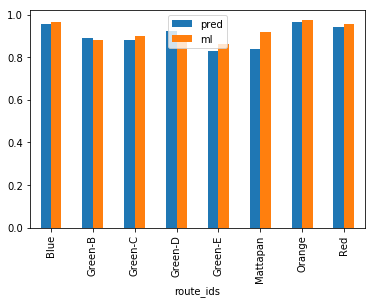

In [26]:
pd.DataFrame({
    'route_ids': ml_acc.index.values, 
    'pred': pred_acc.values, 
    'ml': ml_acc.values
}).plot(kind='bar', x='route_ids')